#Work Safety

## Environment Preparation

In [ ]:
#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#We access the folder we will use
%cd /content/drive/MyDrive/yolov8/WorkSafety

/content/drive/MyDrive/yolov8/WorkSafety


In [1]:
#We download the ultralytics library and include it in the project
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.52 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


##Dataseti klasöre ayıklama

In [2]:
#We are extracting training data that we uploaded to Google Drive.
!unzip data/splitdata.zip -d ./data

unzip:  cannot find or open data/splitdata.zip, data/splitdata.zip.zip or data/splitdata.zip.ZIP.


##Training

In [ ]:
#Trainig
#Epoch = number of repetitions
#imgsz = image size
#batch = The number of data the model processes at each step
#workers = Number of parallel workers used for data loading
#Parallel workers speed up data loading processes and shorten training times
#Using more workers can provide faster training in some cases, but care must be taken with system resources.
from ultralytics import YOLO
!yolo detect train model=yolov8n.pt data=data/config.yaml epochs=10 imgsz=640 batch=8 workers=8 device=0 name=yolov8n_worksafe_detect


In [ ]:
#if education is left unfinished
!yolo detect train model=runs/detect/yolov8n_worksafe_detect/weights/last.pt resume=true

## Prediction

###Predict for Images

In [ ]:
import ultralytics
ultralytics.checks()
#model = model resulting from training
#source = folder with test photos
#save = to save the results
!yolo detect predict model=runs/detect/yolov8n_worksafe_detect/weights/best.pt source=inference save=True




###Predict for Video

In [ ]:
import ultralytics
ultralytics.checks()

!yolo detect predict model=runs/detect/yolov8n_worksafe_detect/weights/best.pt source=inference/test_02.mp4 save=True




##Double model Trying

###Double Model Predict for Image


0: 640x640 1 person, 9.4ms
Speed: 2.7ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x480 1 Helmet, 1 Vest, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


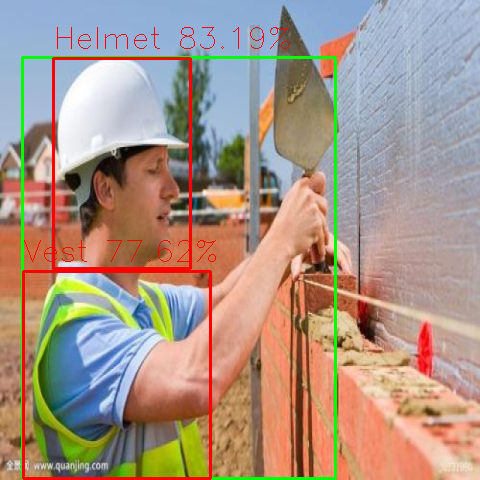

In [ ]:
import cv2
import imutils
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

img_path = "inference/images/000037.jpg" # Test Images path
model_path = "runs/detect/yolov8n_worksafe_detect/weights/best.pt"  # trained model path
model_path_yolov8n = "yolov8n.pt"  #

img = cv2.imread(img_path)
img = imutils.resize(img, width=480)

# first model = Person detect
model_yolov8 = YOLO(model_path_yolov8n)

# second model = helmet and vest detect
model_worksafe = YOLO(model_path)


#first step =  detect person
results = model_yolov8(img)[0]

threshold = 0.5
for result in results.boxes.data.tolist():
    x1, y1, x2, y2, score, class_id = result
    if score > threshold:
        if int(class_id) == 0:  # Person class (class_id 0, COCO data set)
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2) # rectangle for person
            class_name = results.names[int(class_id)]

            #optional
            #text = f"{class_name} {round(score * 100, 2)}%"
            #cv2.putText(img, text, (int(x1), int(y1 - 10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)

            # Use the area where people are detected in the occupational safety model
            person_img = img[int(y1):int(y2), int(x1):int(x2)]  # Trim detected contact
            saferesults = model_worksafe(person_img)[0]  # Work safety detection

            for saferesult in saferesults.boxes.data.tolist():
                sx1, sy1, sx2, sy2, sscore, sclass_id = saferesult
                if sscore > threshold:
                    sx1_original = int(x1) + int(sx1)
                    sy1_original = int(y1) + int(sy1)
                    sx2_original = int(x1) + int(sx2)
                    sy2_original = int(y1) + int(sy2)

                    # rectangle for helmet or vest
                    cv2.rectangle(img, (sx1_original, sy1_original), (sx2_original, sy2_original), (0, 0, 255), 2)
                    class_name = saferesults.names[int(sclass_id)]
                    text = f"{class_name} {round(sscore * 100, 2)}%"
                    cv2.putText(img, text, (sx1_original, sy1_original - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1)


# Show results
cv2_imshow(img)
